In [1]:
# Trying out a regularized linear regression model. The key point is to to log_transform the numeric variables since most of them are skewed.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
# load the data
train = pd.read_csv("Desktop/Python/Kaggle/House Prices/train.csv")
test = pd.read_csv("Desktop/Python/Kaggle/House Prices/test.csv")

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
all_data = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                     test.loc[:, 'MSSubClass': 'SaleCondition']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11522e278>,
      dtype=object)

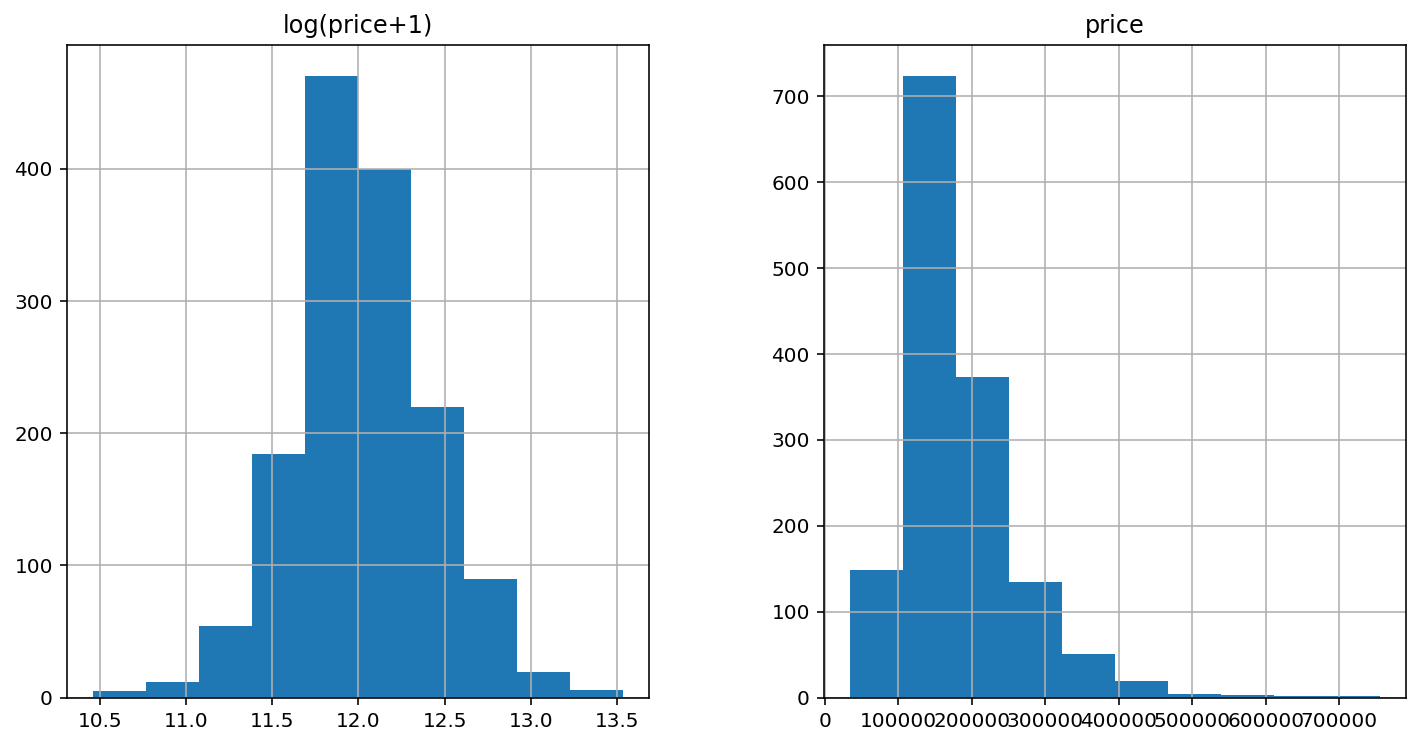

In [5]:
# First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal
# Create Dummy variables for the categorical features
# Replace the numeric missing values (NaN's) with the mean of their respective columns
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"price": train['SalePrice'], "log(price+1)": np.log1p(train['SalePrice'])})
prices.hist()

In [6]:
# log transform the target
train['SalePrice'] = np.log1p(train['SalePrice'])

# log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) # compute skewness

skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [7]:
all_data = pd.get_dummies(all_data)

In [8]:
# filling NA's with the mean of the column
all_data = all_data.fillna(all_data.mean())

In [9]:
# creating matrics for sklearn
X_train = all_data[:train.shape[0]]
X_test = all_data[:test.shape[0]]
y = train.SalePrice

In [10]:
# Models
# I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv=5))
    return(rmse)

In [11]:
model_ridge = Ridge()

In [12]:
# The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]

Text(0,0.5,'rmse')

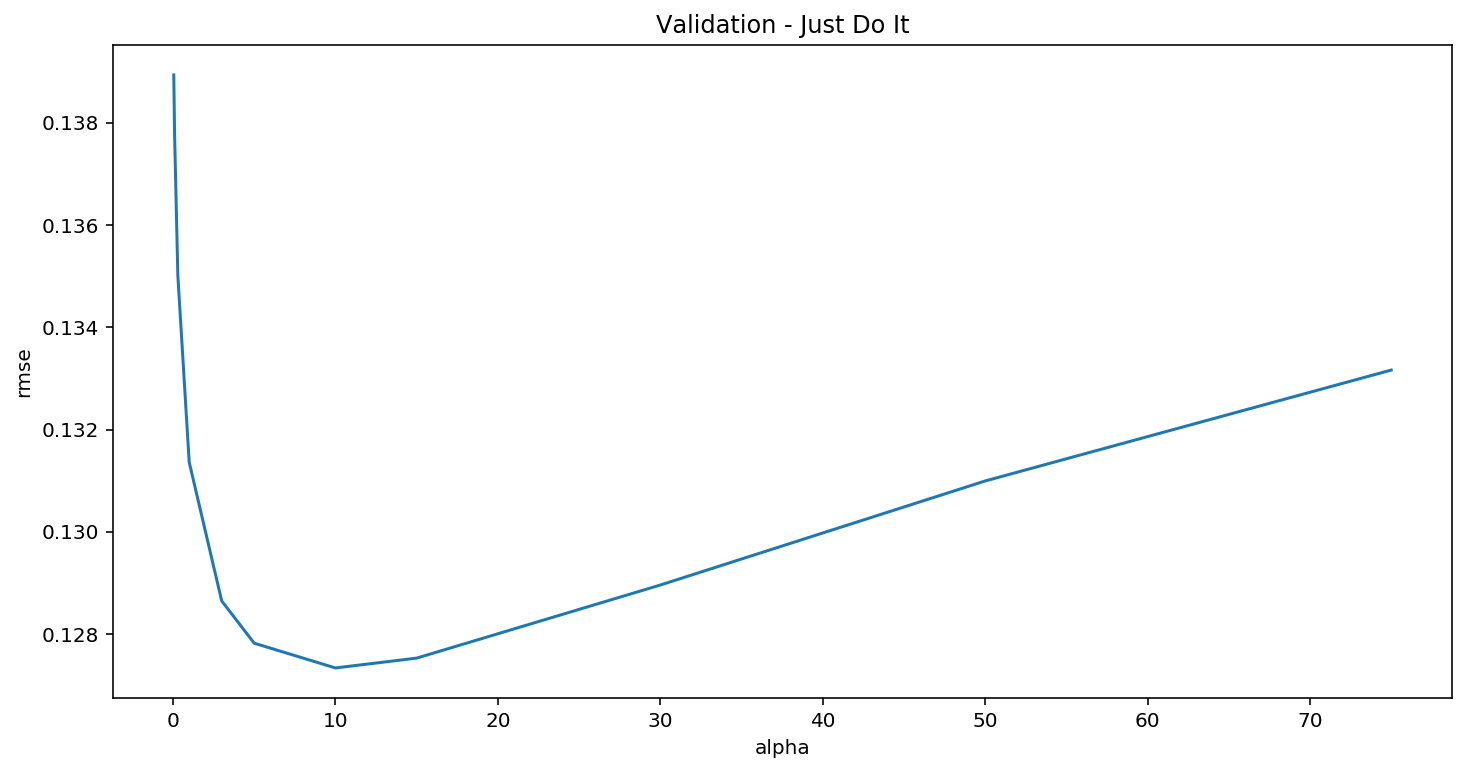

In [13]:
cv_ridge = pd.Series(cv_ridge, index=alphas)
cv_ridge.plot(title='Validation - Just Do It')
plt.xlabel("alpha")
plt.ylabel('rmse')

In [14]:
"""
Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. 
If however we let the model be too flexible (alpha small) the model 
begins to overfit. A value of alpha = 10 is about right based on the plot above.
"""

'\nNote the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. \nIf however we let the model be too flexible (alpha small) the model \nbegins to overfit. A value of alpha = 10 is about right based on the plot above.\n'

In [15]:
cv_ridge.min()

0.12733734668670765

In [16]:
cv_ridge.max()

0.13893637694024527

In [17]:
#Let' try out the Lasso model. We will do a slightly different approach here and use the built in Lasso CV to figure out the best alpha for us. For some reason the alphas in Lasso CV are really the inverse or the alphas in Ridge.
model_lasso = LassoCV(alphas=[1, 0.1, 0.001, 0.0005]).fit(X_train, y)

In [18]:
rmse_cv(model_lasso).mean()

0.12314421090977448

In [19]:
# The lasso performs even better so we'll just use this one to predict on the test set. Another neat thing about the Lasso is that it does feature selection for you - setting coefficients of features it deems unimportant to zero. 
coef = pd.Series(model_lasso.coef_, index=X_train.columns)

In [20]:
print("Lasso picked " + str(sum(coef !=0)) + " variables and eliminated the other " +  str(sum(coef==0))  + ' variables')

Lasso picked 111 variables and eliminated the other 177 variables


In [21]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5,1,'Coefficients in the Lasso Model')

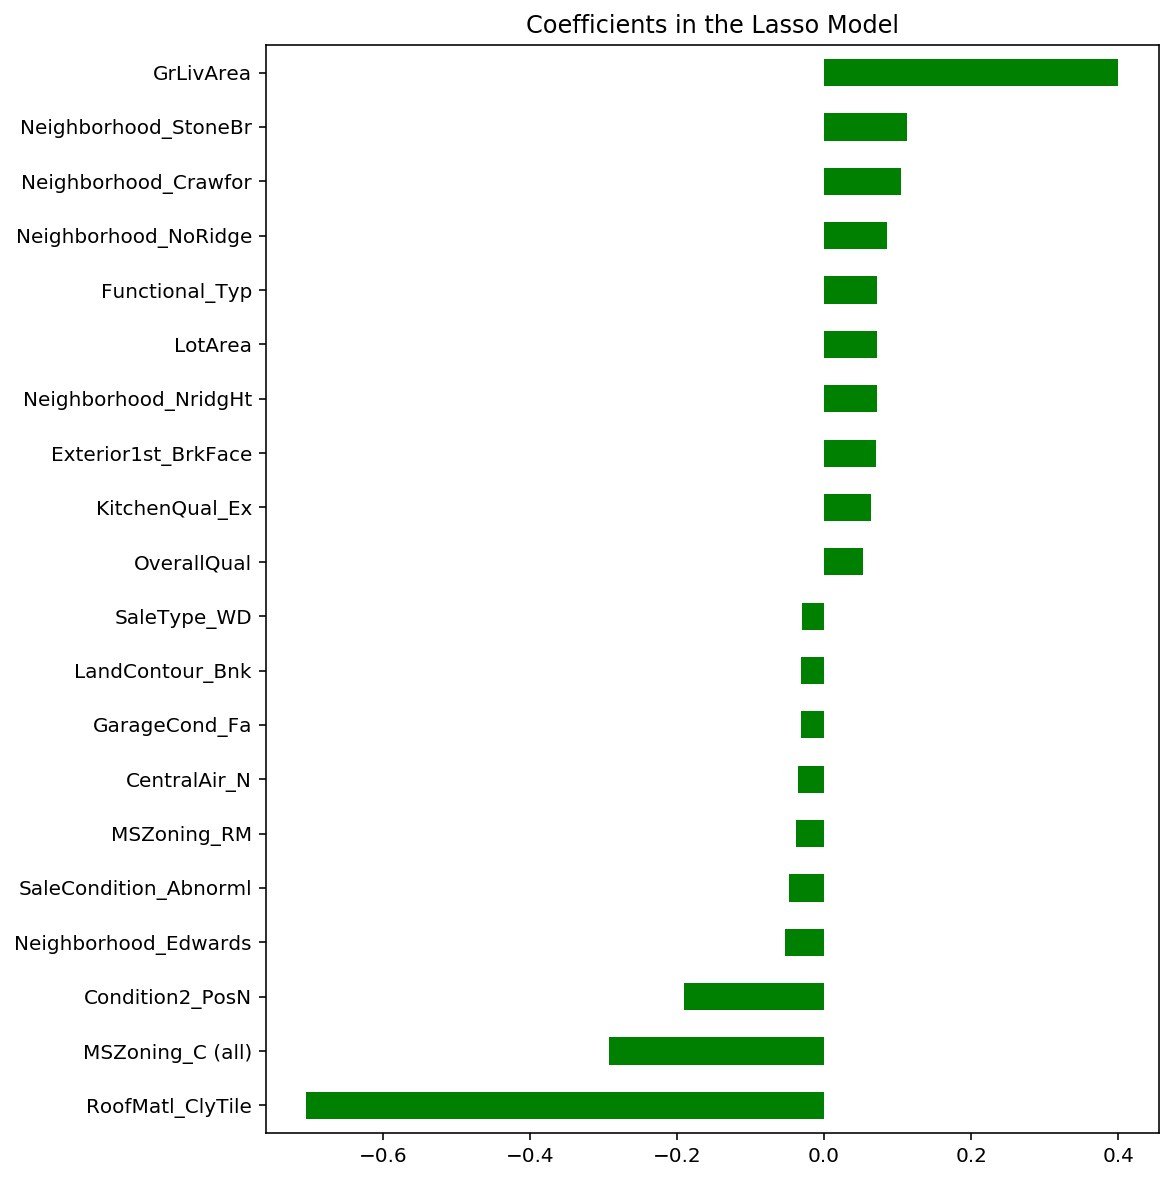

In [22]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = 'barh', color='g')
plt.title('Coefficients in the Lasso Model')

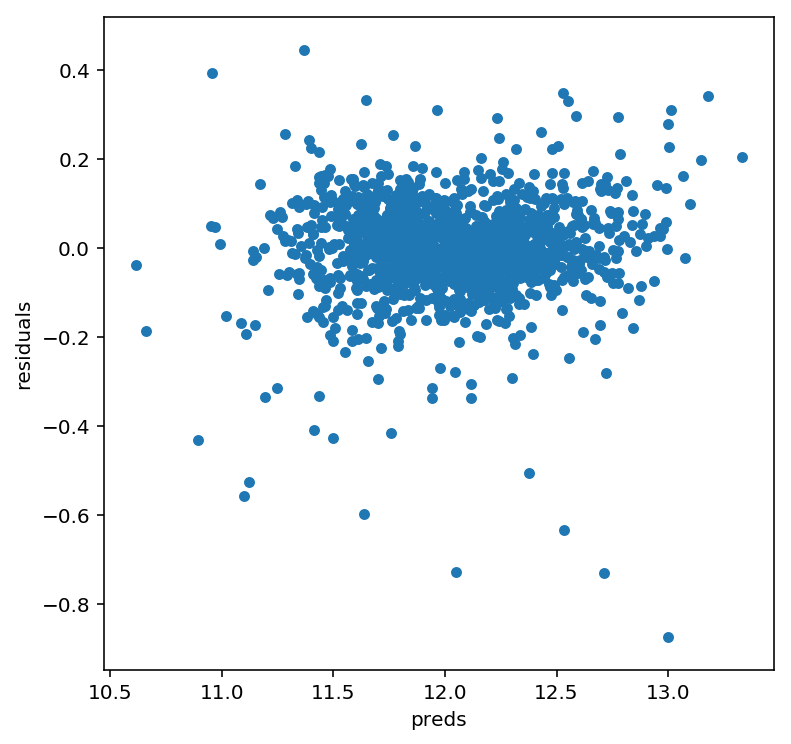

In [23]:
# Let's look at the residuals as well:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds": model_lasso.predict(X_train), "true":y})
preds['residuals'] = preds['true'] - preds['preds']
preds.plot(x='preds', y='residuals', kind='scatter')

In [24]:
# Adding an xgboost model:
import xgboost as xgb

In [25]:
dtrain = xgb.DMatrix(X_train, label=y)
dtest = xgb.DMatrix(X_test)

params = {'max_depth': 2, 'eta':0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds=100)

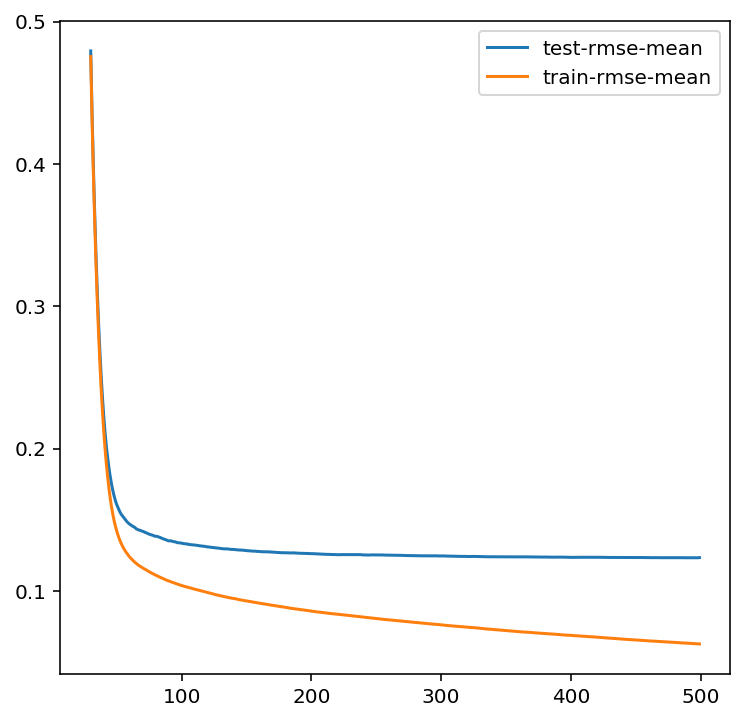

In [26]:
model.loc[30:, ['test-rmse-mean', 'train-rmse-mean']].plot()

In [27]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)
# the params were tuned using xgb.cv
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=360,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [28]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

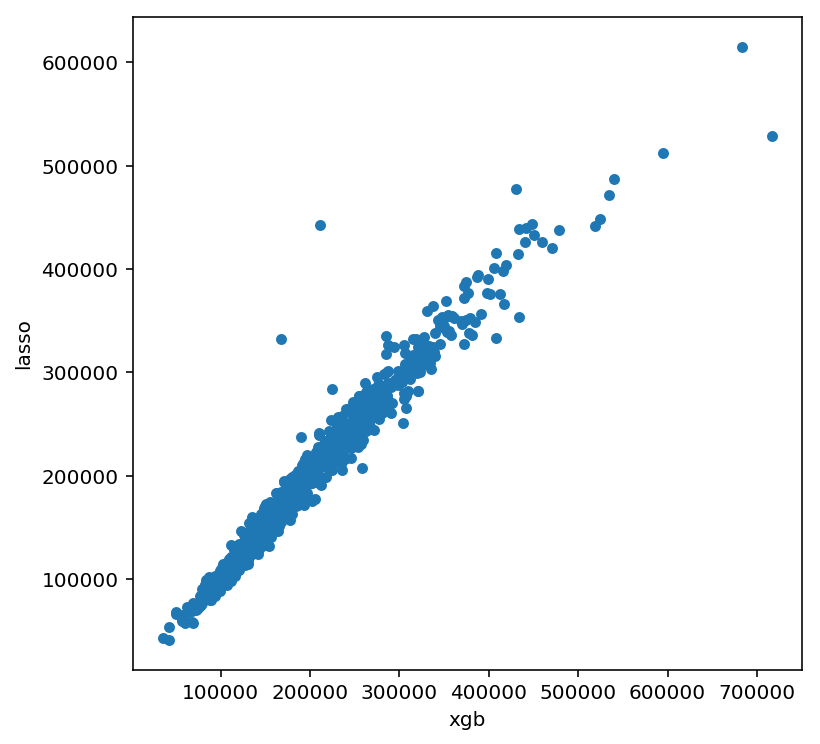

In [29]:
predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x = "xgb", y = "lasso", kind = 'scatter')

In [30]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

In [31]:
solution = pd.DataFrame({"id": test.Id, "SalePrice": preds})
solution.to_csv("Desktop/ridge_sol.csv", index=False)

In [32]:
# Trying out keras
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

/Users/gaoziyao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [33]:
X_train = StandardScaler().fit_transform(X_train)

In [34]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state=3)

In [35]:
X_tr.shape

(1095, 288)

In [36]:
X_tr

array([[ 1.00573733,  0.68066137, -0.46001991, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184,  0.60296111,  0.03113183, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184, -0.02865265, -0.74027492, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ...,
       [ 0.16426234, -0.87075036, -0.81954431, ..., -0.11785113,
        -2.13834494, -0.30599503],
       [ 0.92361154, -0.30038284, -0.44275864, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.83656519,  1.98505948,  0.46455838, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [37]:
model = Sequential()
# model.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer=l1(0.001)))

model.compile(loss = 'mse', optimizer = 'adam')

/Users/gaoziyao/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, input_dim=288, kernel_regularizer=<keras.reg...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [39]:
hist = model.fit(X_tr, y_tr, validation_data=(X_val, y_val))

Train on 1095 samples, validate on 365 samples
Epoch 1/1
1095/1095 [==============================] - 0s 323us/step - loss: 147.0249 - val_loss: 149.9534


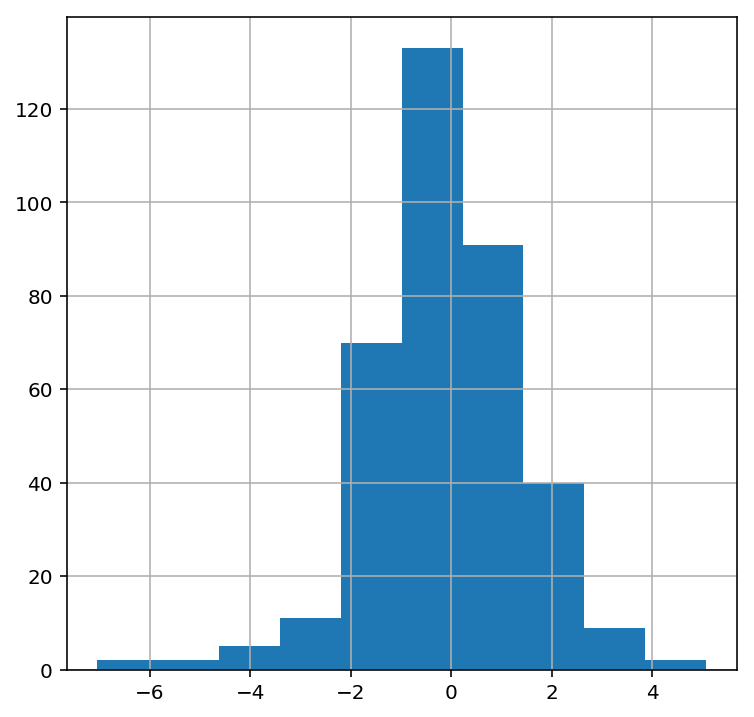

In [41]:
pd.Series(model.predict(X_val)[:,0]).hist()